# 12-3 使用信息熵寻找最优划分

对本节例子的说明：

+ 鸢尾花数据集的特征是连续值，这与我们在《机器学习》《统计学习方法》里面看到的例子有所不同，要注意区分。
+ 这一节的例子很好地说明了如何对连续值的特征做划分
+ 我们回忆一下，信息熵的定义，信息熵是数据不确定性的度量，信息熵越大，数据的不确定性越大，信息熵越小，数据的确定性越大。划分好以后的数据集的信息熵一定要是最小的，才能保证在这个特征的这个划分下，不确定性越小。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, 2:]
y = iris.target

from sklearn.tree import DecisionTreeClassifier

# criterion 评判标准
dt_clf = DecisionTreeClassifier(
    max_depth=2, criterion='entropy', random_state=66)
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=66, splitter='best')

In [2]:
def plot_decision_boundary(model, axis):
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int(
            (axis[1] - axis[0]) * 100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int(
            (axis[3] - axis[2]) * 100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF59D', '#90CAF9'])

    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

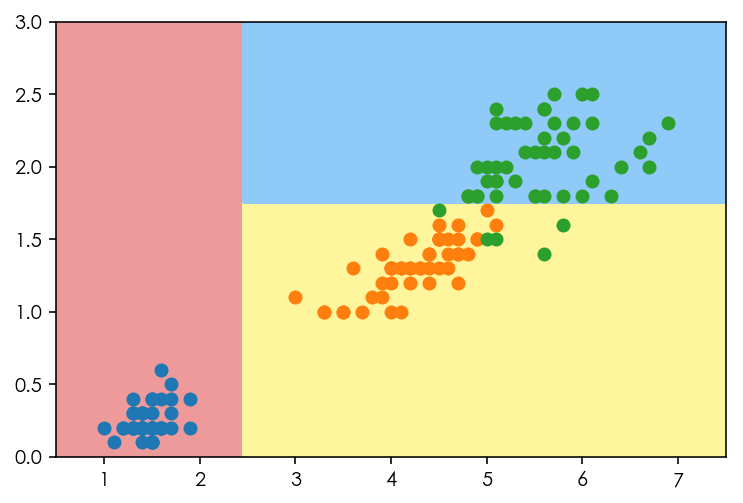

In [3]:
plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y == 0, 0], X[y == 0, 1])
plt.scatter(X[y == 1, 0], X[y == 1, 1])
plt.scatter(X[y == 2, 0], X[y == 2, 1])
plt.show()

## 实现使用信息熵进行划分

In [4]:
# 假设我们已经选定了
def split(X, y, d, value):
    '''
    d：第几个 feature
    value：value 作为划分的 value
    '''
    index_a = (X[:, d] <= value)
    index_b = (X[:, d] > value)
    return X[index_a], X[index_b], y[index_a], y[index_b]

In [5]:
from collections import Counter
from math import log


def entropy(y):
    counter = Counter(y)
    res = 0.0
    for num in counter.values():
        p = num / len(y)  # 计算一下，这个类别的概率
        res += -p * log(p)
    return res


def try_split(X, y):
    best_entropy = float('inf')
    best_d, best_v = -1, -1  # 最佳的 feature ，最佳的划分值
    for d in range(X.shape[1]):
        sorted_index = np.argsort(X[:, d])
        for i in range(1, len(X)):
            if X[sorted_index[i], d] != X[sorted_index[i - 1], d]:
                v = (X[sorted_index[i], d] + X[sorted_index[i - 1], d]) / 2
                X_l, X_r, y_l, y_r = split(X, y, d, v)
                # 注意理解这一行代码：我们回忆一下，信息熵的定义，信息熵是数据不确定性的度量，信息熵越大，数据的不确定性越大，信息熵越小，数据的确定性越大。划分好以后的数据集的信息熵一定要是最小的，才能保证在这个特征的这个划分下，不确定性越小。
                e = entropy(y_l) + entropy(y_r)
                if e < best_entropy:
                    best_entropy = e
                    best_d = d
                    best_v = v
    return best_entropy, best_d, best_v

我们首先将数据集放入视图做决策划分的函数中，看看应该选取哪个特征，使用哪个边界值做划分最合适。

In [6]:
best_entropy, best_d, best_v = try_split(X, y)
print("最小的信息熵", best_entropy)
print("最小的信息熵的特征对应第几个索引", best_d)
print("最小的信息熵的特征的划分阈值", best_v)

最小的信息熵 0.6931471805599453
最小的信息熵的特征对应第几个索引 0
最小的信息熵的特征的划分阈值 2.45


得到了最佳划分特征和最佳的划分边界值以后，我们就可以对数据进行划分了。

In [7]:
# 第一层划分
X1_l, X1_r, y1_l, y1_r = split(X, y, best_d, best_v)

下面计算一下划分以后的两个数据集的信息熵。

In [8]:
entropy(y1_l)

0.0

再看看 y1_l。

In [9]:
y1_l

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

的确很“纯”，说明我们的算法是正确的。

In [10]:
entropy(y1_r)

0.6931471805599453

接下来继续做划分。左边的是很纯的，所以就要对右边的数据集做划分了，同样地，我们要对右边的数据集去计算一下，应该是用哪个特征，哪个边界值。

In [11]:
best_entropy2, best_d2, best_v2 = try_split(X1_r, y1_r)

In [12]:
best_entropy2

0.4132278899361904

In [13]:
best_d2

1

In [14]:
best_v2

1.75

In [15]:
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_d2, best_v2)

In [16]:
y2_l

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [17]:
y2_r

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [18]:
entropy(y2_l)

0.30849545083110386

In [19]:
entropy(y2_r)

0.10473243910508653

## 信息熵与基尼系数

+ 信息熵的计算比基尼系数稍慢
+ scikit-learn 中默认使用基尼系数
+ 大多数时候，二者没有特别的效果优劣